In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fl_g13.config import RAW_DATA_DIR
from fl_g13.modeling import train, eval, save, load

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader

2025-04-18 09:40:41.579 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: /home/massimiliano/Projects/fl-g13


## Boilerplate usecase of Dino

Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main


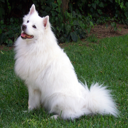

Predicted label: grey wolf (269)


In [3]:
from torchvision import models
from torchvision.transforms import Compose, Normalize, ToTensor

import requests
from IPython.display import display
from PIL import Image

# Load the pretrained DINO ViT-S/16 model
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=True)
model.eval()  # Set the model to evaluation mode

# Download a sample image from ImageNet
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB")
display(img.resize((128, 128)))

imagenet_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Preprocess the image
input_tensor = imagenet_transform(img).unsqueeze(0)  # Add batch dimension

# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_tensor = input_tensor.to(device)

# Perform inference
with torch.no_grad():
    output = model(input_tensor)

# Load ImageNet class labels
imagenet_classes_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_classes = requests.get(imagenet_classes_url).json()

# Get the predicted label string
predicted_label = output.argmax(dim=1).item()
predicted_label_str = imagenet_classes[predicted_label]
print(f"Predicted label: {predicted_label_str} ({predicted_label})")

## Load data

In [4]:
from torchvision import models
from torchvision.transforms import Compose, Resize, CenterCrop, RandomCrop, RandomHorizontalFlip, RandomVerticalFlip, Normalize, ToTensor

# Define preprocessing pipeline
train_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    RandomCrop(224), # But Dino works on 224x224
    RandomHorizontalFlip(),
    #RandomVerticalFlip(), # Dino was not pretrained with Vertical flip, lets avoid
    ToTensor(),
    Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]),
])

eval_transform = Compose([
    Resize(256), # CIFRA100 is originally 32x32
    CenterCrop(224), # But Dino works on 224x224
    ToTensor(),
    Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2673, 0.2564, 0.2762]),
])

cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=train_transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=eval_transform)

In [5]:
train_dataloader = DataLoader(cifar100_train)
test_dataloader = DataLoader(cifar100_test)

In [6]:
# Uncomment to extract mean and var
# WARNING: DO NOT RUN IF YOU APPLY OTHER TRANSOFRMATIONS THAN ToTensor()

# # Stack all images into a single tensor
# all_images = torch.cat([cifar100_train[i][0].unsqueeze(0) for i in range(len(cifar100_train))], dim=0)

# print(all_images.shape)

# # Calculate mean and std for each channel (RGB)
# mean = all_images.mean(dim=(0, 2, 3))  # Mean across batch, height, and width
# std = all_images.std(dim=(0, 2, 3))    # Std across batch, height, and width

# print(f"Mean: {mean}")
# print(f"Std: {std}")

## Train Model

In [7]:
from timm.layers import DropPath

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dropout_rate = 0.1      # Dropout rate for MLP and attention layers
drop_path_rate = 0.1    # DropPath rate for stochastic depth (drops some residuals) -- probably will have to ignore in FedLearn setting

# Load model from torch
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=True)
model.head = nn.Sequential(
    nn.Linear(384, 1024),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Dropout(p=dropout_rate),
    nn.Linear(1024, 100),
)
def initialize_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)

model.head.apply(initialize_weights)

# Add dropout to attention layers
for block in model.blocks:
    block.attn.attn_drop = nn.Dropout(p=dropout_rate)  # Dropout in attention
    block.attn.proj_drop = nn.Dropout(p=dropout_rate)  # Dropout in projection
    block.mlp.drop = nn.Dropout(p=dropout_rate)  # Dropout in MLP

# Add DropPath to transformer blocks
for i, block in enumerate(model.blocks):
    drop_prob = drop_path_rate * (i / len(model.blocks))  # Linearly scale drop rate through blocks
    block.drop_path = DropPath(drop_prob)  # DropPath

# Freeze whole model
for param in model.parameters():
    param.requires_grad = False

# Allow to access some of the blocks in the backbone
for param in model.blocks[-3:].parameters():
    param.requires_grad = True

# Also allow the LayerNorm
for param in model.norm.parameters():
    param.requires_grad = True

# And obviously the head (MLP)
for param in model.head.parameters():
    param.requires_grad = True

model.to(device)

/home/massimiliano/miniconda3/envs/fl-g13/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/massimiliano/.cache/torch/hub/facebookresearch_dino_main


Using device: cuda


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.1, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.1, inplace=False)
      )
      (drop_path): DropPath(drop_prob=0.000)
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
 

In [8]:
CHECKPOINT_DIR = "/home/massimiliano/Projects/fl-g13/checkpoints"

# Hyper-parameters
batch_size = 128
start_epoch = 1
num_epochs = 5
save_every = 1

# Optimizer and loss
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
criterion = torch.nn.CrossEntropyLoss()

# Preallocated lists: if the training interrupts, it will still save their values
all_training_losses=[]       # Pre-allocated list for training losses
all_validation_losses=[]     # Pre-allocated list for validation losses
all_training_accuracies=[]   # Pre-allocated list for training accuracies
all_validation_accuracies=[] # Pre-allocated list for validation accuracies

# Train the model and save periodically
_, _, _, _ = train(
    checkpoint_dir=CHECKPOINT_DIR,
    prefix="", # Automatically find a name for the model
    start_epoch=start_epoch,
    num_epochs=num_epochs,
    save_every=save_every,
    train_dataloader=train_dataloader,
    val_dataloader=test_dataloader,
    model=model, # Use the same model as before (partially pre-trained)
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    verbose=False,
    all_training_losses=all_training_losses,  # Pre-allocated list for training losses
    all_validation_losses=all_validation_losses,  # Pre-allocated list for validation losses
    all_training_accuracies=all_training_accuracies,  # Pre-allocated list for training accuracies
    all_validation_accuracies=all_validation_accuracies,  # Pre-allocated list for validation accuracies
)

No prefix/name for the model was provided, choosen prefix/name: plucky_nidoran_18

🚀 Epoch 1/5 (20.00%) Completed
	📊 Training Loss: 4.3801
	✅ Training Accuracy: 8.76%
	⏳ Elapsed Time: 432.83s | ETA: 1731.31s
	🕒 Completed At: 09:47
🔍 Validation Results:
	📉 Validation Loss: 3.6688
	🎯 Validation Accuracy: 22.69%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/plucky_nidoran_18_epoch_1.pth

🚀 Epoch 2/5 (40.00%) Completed
	📊 Training Loss: 3.2310
	✅ Training Accuracy: 23.58%
	⏳ Elapsed Time: 411.32s | ETA: 1233.96s
	🕒 Completed At: 09:55
🔍 Validation Results:
	📉 Validation Loss: 3.4178
	🎯 Validation Accuracy: 28.24%

💾 Saved checkpoint at: /home/massimiliano/Projects/fl-g13/checkpoints/plucky_nidoran_18_epoch_2.pth

🚀 Epoch 3/5 (60.00%) Completed
	📊 Training Loss: 2.9085
	✅ Training Accuracy: 29.07%
	⏳ Elapsed Time: 413.74s | ETA: 827.47s
	🕒 Completed At: 10:02
🔍 Validation Results:
	📉 Validation Loss: 3.3040
	🎯 Validation Accuracy: 30.72%

💾 Saved checkpoint at: /hom

KeyboardInterrupt: 

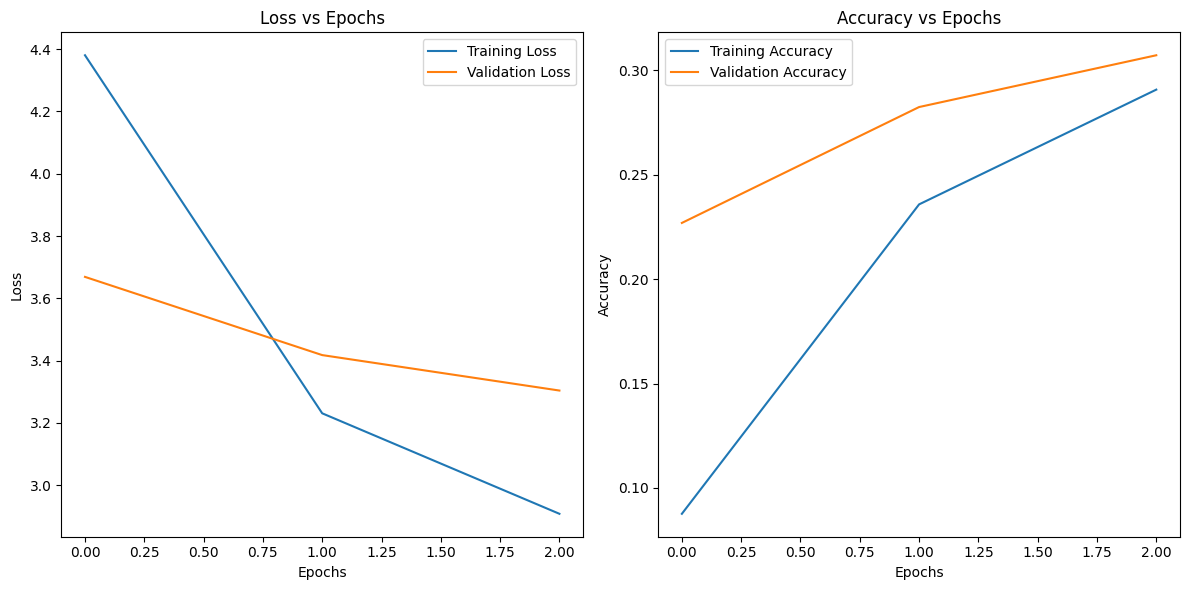

In [9]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(all_training_losses, label='Training Loss')
plt.plot(all_validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(all_training_accuracies, label='Training Accuracy')
plt.plot(all_validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()